# NCAA ML Competition - Women's 2018
## W207 Final Project
## Julia Buffinton, Charlene Chen, Arvindh Ganesan, Prashant Kumar Sahay
### Due: 4/17/18

## Import Relevant Libraries

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

/Users/chenyingcharlene/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/chenyingcharlene/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Load regular season data

In [2]:
# Load the data
data_dir = './WStage2DataFiles/'
df_seeds = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_tour_compact = pd.read_csv(data_dir + 'WNCAATourneyCompactResults.csv')
df_tour_detail = pd.read_csv(data_dir + 'WNCAATourneyDetailedResults.csv')
df_reg_compact = pd.read_csv(data_dir + 'WRegularSeasonCompactResults.csv')
df_reg_detail = pd.read_csv(data_dir + 'WRegularSeasonDetailedResults.csv')
df_teams = pd.read_csv(data_dir + 'WTeams.csv')
df_teams_leagues = pd.merge(left=df_teams, right=pd.read_csv(data_dir + 'WLeagues.csv'), how='left', on=['TeamName'])
df_tour_18 = pd.read_csv('NCAA_Result_2018_sep.csv')

## Get just numeric seeds - we aren't interested in region

In [3]:
# get just integer value of seed (exclude region information)
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['SeedInt'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

## Load the league that each team belongs to

In [4]:
df_winning_team_leagues = df_teams_leagues.rename(columns={'TeamID' : 'WTeamID', 'LeagueName' : 'WLeagueName'}).drop('TeamName',1)
df_winning_team_leagues.head()

,WTeamID,WLeagueName
0,3101,Southland
1,3102,MWC
2,3103,MAC
3,3104,SEC
4,3105,SWAC


## Load and bin league performance (to dampen the effect of small variations)

In [5]:
## Bin league performance into 10 bins
df_league_perf = pd.read_pickle('league_performance')
df_league_perf['Leaguebin'] = pd.cut(df_league_perf['PctWins mean'], 24, labels=False)

df_league_perf = df_league_perf[['LeagueName', 'Leaguebin']]
df_team_league_perf = pd.merge(left=df_teams_leagues, right=df_league_perf, how='left', on=['LeagueName'])

df_team_league_perf = df_team_league_perf[['TeamID', 'Leaguebin']]
df_team_league_perf.head()

,TeamID,Leaguebin
0,3101,1.0
1,3102,7.0
2,3103,2.0
3,3104,23.0
4,3105,0.0


In [6]:
## Inject winning and losing teams' leaugues into df
# Total of 36 columns
df_reg_detail = pd.merge(left=df_reg_detail, right=df_winning_team_leagues, how='left', on=['WTeamID'])

df_losing_team_leagues = df_winning_team_leagues.rename(columns={'WTeamID': 'LTeamID', 'WLeagueName': 'LLeagueName'})
df_reg_detail = pd.merge(left=df_reg_detail, right=df_losing_team_leagues, how='left', on=['LTeamID'])
df_reg_detail.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WLeagueName,LLeagueName
0,2010,11,3103,63,3237,49,H,0,23,54,...,10,11,27,11,23,7,6,19,MAC,Horizon
1,2010,11,3104,73,3399,68,N,0,26,62,...,27,14,26,7,20,4,2,27,SEC,OVC
2,2010,11,3110,71,3224,59,A,0,29,62,...,23,17,23,8,15,6,0,15,Patriot,MEAC
3,2010,11,3111,63,3267,58,A,0,27,52,...,25,22,22,15,11,14,5,14,Sun Belt,C-USA
4,2010,11,3119,74,3447,70,H,1,30,74,...,21,21,32,12,14,4,2,14,Patriot,NEC


## Feature Engineering
-  Operationalize the notion of Point Opportunities Developed (POD) and Opportunity Convertion Rate (OCR)
-  Demean and rescale the performance of teams by league and season
-  Bin performance to dampen small variations


In [7]:
## Add a few more columns 
## Now have a total of 44 columns

df_reg_detail['WPOD'] = df_reg_detail.WFGA3 * 3 + (df_reg_detail.WFGA - df_reg_detail.WFGA3) * 2 + df_reg_detail.WFTA * 1
df_reg_detail['LPOD'] = df_reg_detail.LFGA3 * 3 + (df_reg_detail.LFGA - df_reg_detail.LFGA3) * 2 + df_reg_detail.LFTA * 1

df_reg_detail['WOCR'] = 1.0 * df_reg_detail.WScore / df_reg_detail.WPOD
df_reg_detail['LOCR'] = 1.0 * df_reg_detail.LScore / df_reg_detail.LPOD

df_reg_detail['WFGP'] = df_reg_detail.WFGM / df_reg_detail.WFGA ## Field goal percentage for the winning team
df_reg_detail['LFGP'] = df_reg_detail.LFGM / df_reg_detail.LFGA ## Field goal percentage for the losing team

df_reg_detail['WFTP'] = df_reg_detail.WFTM / df_reg_detail.WFTA ## Field goal percentage for the winning team
df_reg_detail['LFTP'] = df_reg_detail.LFTM / df_reg_detail.LFTA ## Field goal percentage for the losing team

In [8]:
features_todo = ['FGP','FTP','FGA','FTA','Ast','Blk','OR','DR','POD','OCR','Stl']

In [9]:
# take in string of feature name
def calc_feats(dat,feat_list):
    
    # get just the list of teams, to build our features from
    w_cols = dat[[col for col in dat if col.startswith('W')]].copy()
    w_cols.columns = [s[1:] for s in w_cols.columns]
    w_cols['Season'] = dat['Season']
    
    l_cols = dat[[col for col in dat if col.startswith('L')]].copy()
    l_cols.columns = [s[1:] for s in l_cols.columns]
    l_cols['Season'] = dat['Season']
    
    # this is a dataframe with all games for each season, with relevant stats for each team on a row
    all_teams = pd.concat([w_cols,l_cols])
    
    all_tm_lg_szn = all_teams[['TeamID','LeagueName','Season']].drop_duplicates()
    
    for f in feat_list:
        # aggregate data
        team_agg = all_teams.groupby(['Season', 'LeagueName', 'TeamID'], as_index=False).agg({f:['mean']})
        team_agg.columns = team_agg.columns.droplevel(1)

        league_agg = all_teams.groupby(['Season', 'LeagueName'], as_index=False).agg({f:['mean','std']})
        league_agg.columns = [''.join(col).strip() for col in league_agg.columns.values]
        
        team_agg = pd.merge(left=team_agg,right=league_agg,how='left',on=['Season','LeagueName'])
        
        team_agg[f+'norm'] = ((team_agg[f] - team_agg[f+'mean'])/ team_agg[f+'std'])
        team_agg[f+'bin'] = pd.cut(team_agg[f+'norm'], 24, labels=False)
        
        all_tm_lg_szn = pd.merge(left=all_tm_lg_szn,right=team_agg,how='left',on=['Season','LeagueName','TeamID'])
            
    return all_tm_lg_szn  

In [10]:
# note: this includes teams from 2018
df_engineered_features = calc_feats(df_reg_detail,features_todo)
df_engineered_features = pd.merge(left=df_engineered_features,right=df_team_league_perf,how='left',on='TeamID')

In [11]:
# This has 10 fewer columns than Prashant's because it doesn't have duplicate LeagueName columns
df_engineered_features.head()

,TeamID,LeagueName,Season,FGP,FGPmean,FGPstd,FGPnorm,FGPbin,FTP,FTPmean,...,OCRmean,OCRstd,OCRnorm,OCRbin,Stl,Stlmean,Stlstd,Stlnorm,Stlbin,Leaguebin
0,3103,MAC,2010,0.405346,0.402665,0.072138,0.037166,10,0.704329,0.698111,...,0.432482,0.068308,0.104973,11,8.033333,9.304709,3.193953,-0.398057,5,2.0
1,3104,SEC,2010,0.400770,0.415768,0.074202,-0.202128,8,0.621109,0.676910,...,0.437030,0.071290,-0.327385,7,7.379310,8.371495,3.859940,-0.257047,6,23.0
2,3110,Patriot,2010,0.399550,0.381652,0.067985,0.263277,12,0.740438,0.686326,...,0.410244,0.065445,0.343623,14,7.952381,7.600000,3.381968,0.104194,9,0.0
3,3111,Sun Belt,2010,0.435525,0.394316,0.076786,0.536670,14,0.622631,0.671585,...,0.422639,0.073208,0.376765,14,9.935484,8.425287,3.595169,0.420063,11,1.0
4,3119,Patriot,2010,0.358097,0.381652,0.067985,-0.346465,7,0.673364,0.686326,...,0.410244,0.065445,-0.471252,6,6.458333,7.600000,3.381968,-0.337575,5,0.0


In [12]:
# Create 'winning team' and 'losing team' versions of engineered features DF
# TO align with Prashant, this needs to only contain 'Bin' features. Season, and teamID

df_engineered_features_w = df_engineered_features[[col for col in df_engineered_features if col.endswith('bin')]].copy()
df_engineered_features_w.columns = map(lambda x:'1'+x,df_engineered_features_w.columns)
df_engineered_features_w['Season'] = df_engineered_features['Season']
df_engineered_features_w['1TeamID'] = df_engineered_features['TeamID']

df_engineered_features_l = df_engineered_features[[col for col in df_engineered_features if col.endswith('bin')]].copy()
df_engineered_features_l.columns = map(lambda x:'2'+x,df_engineered_features_l.columns)
df_engineered_features_l['Season'] = df_engineered_features['Season']
df_engineered_features_l['2TeamID'] = df_engineered_features['TeamID']

In [13]:
df_engineered_features_l.head()

,2FGPbin,2FTPbin,2FGAbin,2FTAbin,2Astbin,2Blkbin,2ORbin,2DRbin,2PODbin,2OCRbin,2Stlbin,2Leaguebin,Season,2TeamID
0,10,14,7,12,10,6,12,11,6,11,5,2.0,2010,3103
1,8,9,11,10,9,6,11,14,10,7,6,23.0,2010,3104
2,12,17,9,13,8,13,14,9,9,14,9,0.0,2010,3110
3,14,10,11,9,16,22,13,17,9,14,11,1.0,2010,3111
4,7,12,9,8,5,10,13,10,8,6,5,0.0,2010,3119


## Build Regular Season and Tournament Datasets

In [14]:
# This function can be used to reverse winning and losing teams
# to make datapoints with Result = 0
def gen_neg_items(df):
    df_wins = pd.DataFrame()
    df_wins['Season'] = df['Season']
    df_wins['1TeamID'] = df['WTeamID']
    df_wins['2TeamID'] = df['LTeamID']
    df_wins['Result'] = 1

    df_losses = pd.DataFrame()
    df_losses['Season'] = df['Season']
    df_losses['1TeamID'] = df['LTeamID']
    df_losses['2TeamID'] = df['WTeamID']
    df_losses['Result'] = 0
    
    return pd.concat((df_wins, df_losses))

In [15]:
df_regular_season_games = gen_neg_items(df_reg_detail[df_reg_detail['Season'] > 2009])

In [16]:
df_regular_season_games_with_features = pd.merge(left=df_regular_season_games, right=df_engineered_features_w, on=['Season', '1TeamID'])
df_regular_season_games_with_features = pd.merge(left=df_regular_season_games_with_features, right=df_engineered_features_l, on=['Season', '2TeamID'])

In [17]:
# This is the training dataset for model 1
# Contains all matchups from regular season games 2010-18
# These are duplicated for both 'win' and 'loss' outcomes 
df_regular_season_games_with_features.head()

,Season,1TeamID,2TeamID,Result,1FGPbin,1FTPbin,1FGAbin,1FTAbin,1Astbin,1Blkbin,...,2FGAbin,2FTAbin,2Astbin,2Blkbin,2ORbin,2DRbin,2PODbin,2OCRbin,2Stlbin,2Leaguebin
0,2010,3103,3237,1,10,14,7,12,10,6,...,5,14,2,15,12,11,5,6,7,4.0
1,2010,3231,3237,1,6,12,14,14,6,2,...,5,14,2,15,12,11,5,6,7,4.0
2,2010,3282,3237,1,12,14,10,11,10,7,...,5,14,2,15,12,11,5,6,7,4.0
3,2010,3282,3237,1,12,14,10,11,10,7,...,5,14,2,15,12,11,5,6,7,4.0
4,2010,3293,3237,1,12,19,13,12,12,13,...,5,14,2,15,12,11,5,6,7,4.0


In [18]:
# While we're at it, let's build our training dataset for our second model
# THis is all actual tournament data from 2010-18

# Key difference: 2010-17 tourneys by win-lose team
# 2018 is organized by team #

# DOUBLE CHECK THIS 
df_tour = df_tour_detail[df_tour_detail['Season'] > 2009]
df_tour = df_tour[['Season', 'WTeamID', 'LTeamID']]

# this now also includes 0 outcome items
df_tour = gen_neg_items(df_tour)
df_tour.shape

(1008, 4)

In [19]:
df_tour_18 = df_tour_18.rename(columns={'Team1':'1TeamID', 'Team2':'2TeamID'})

df_tour_matchups = pd.concat([df_tour, df_tour_18], ignore_index=False)
df_tour_matchups.shape

(1071, 4)

In [20]:
# Inject regular season stats to tournament games
df_tour_matchups_with_features = pd.merge(left=df_tour_matchups, right=df_engineered_features_w, on=['Season', '1TeamID'])
df_tour_matchups_with_features = pd.merge(left=df_tour_matchups_with_features, right=df_engineered_features_l, on=['Season', '2TeamID'])

## Train Model 1 on Regular Season Results

In [21]:
# For 8 teams, we are missing league information so we've had to drop those from our dataset
df_train_1 = df_regular_season_games_with_features.dropna(how='any')

## UPDATE THIS IF WE WANT TO DROP FEATURES
df_train_1 = df_train_1

################
# Separate training and test data based on season played
# Will eventually be predicting 2018 matchups, so that must be test
X_train_1 = df_train_1[df_train_1['Season'] < 2018]
X_test_1 = df_train_1[df_train_1['Season'] == 2018]

y_train_1 = X_train_1.Result.values
y_test_1 = X_test_1.Result.values

# split data before 2018 to train and dev
#X_train_1, X_dev, y_train_1, y_dev = train_test_split(X_train_1, y_train_1, test_size=0.33, random_state=42)

X_train_1 = X_train_1.drop('Result', 1)
X_test_1 = X_test_1.drop('Result', 1)

In [22]:
 def eval(clf,train_x,train_y):
    clf.fit(train_x,train_y)
    acc = cross_val_score(clf, train_x, train_y, cv=5, scoring='accuracy')
    print ('Accuracy by CV =', np.mean(acc), acc)
    
    logloss = cross_val_score(clf, train_x, train_y, cv=5, scoring='neg_log_loss')
    print ('Log Loss by CV =', -np.mean(logloss), -logloss)

In [23]:
print ('fitting logistic regression model')
modelLR = LogisticRegression()
eval(modelLR,X_train_1,y_train_1)

print ('\nfitting Naive Bayes model')
modelNB = GaussianNB()
eval(modelNB,X_train_1,y_train_1)

print ('\nfitting Random Forest model')
modelRF = RandomForestClassifier(n_jobs=2, random_state=0)
eval(modelRF,X_train_1,y_train_1)

fitting logistic regression model
Accuracy by CV = 0.728267715089 [ 0.73046495  0.71665044  0.72316212  0.73332522  0.73773585]
Log Loss by CV = 0.527175669716 [ 0.52984793  0.53735087  0.53128064  0.52140304  0.51599587]

fitting Naive Bayes model
Accuracy by CV = 0.690791099237 [ 0.68263145  0.68944742  0.68719572  0.69632425  0.69835666]
Log Loss by CV = 0.73855879001 [ 0.76781505  0.74201815  0.74620983  0.71053989  0.72621104]

fitting Random Forest model
Accuracy by CV = 0.682854947756 [ 0.67642405  0.68165774  0.68591772  0.68902142  0.6812538 ]
Log Loss by CV = 0.717963412351 [ 0.71422789  0.74294204  0.73021414  0.71653986  0.68589312]


## Engineer Feature 'winprob' for tournament matchups based on regular season data

In [24]:
df_tour_matchups_with_features.head()

,Season,1TeamID,2TeamID,Result,1FGPbin,1FTPbin,1FGAbin,1FTAbin,1Astbin,1Blkbin,...,2FGAbin,2FTAbin,2Astbin,2Blkbin,2ORbin,2DRbin,2PODbin,2OCRbin,2Stlbin,2Leaguebin
0,2010,3124,3201,1,14,16,8,20,11,18,...,14,14,12,6,12,13,15,13,12,7.0
1,2010,3124,3207,1,14,16,8,20,11,18,...,12,16,13,6,16,2,13,10,17,15.0
2,2010,3265,3207,0,15,22,10,15,13,13,...,12,16,13,6,16,2,13,10,17,15.0
3,2010,3124,3397,1,14,16,8,20,11,18,...,11,11,12,17,13,18,9,16,5,23.0
4,2010,3173,3397,0,13,14,15,16,13,14,...,11,11,12,17,13,18,9,16,5,23.0


In [25]:
## UPDATE columns used as needed
df_train_2 = df_tour_matchups_with_features

# Need to make predictions for everything in tournament data
# Do not separate 2018 from everything else - need to generate predictions

X_train_2 = df_train_2
y_train_2 = X_train_2.Result.values
X_train_2 = X_train_2.drop('Result', 1)

In [26]:
# Use Naive Bayes Probabilities
## WHY NB vs. LR?

# DOUBLE CHECK on this ordering
df_tour_winprob = pd.DataFrame(modelNB.predict_proba(X_train_2), columns=['LossProb','WinProb'])

df_tour_winprob = pd.concat([X_train_2, df_tour_winprob],axis=1)

df_tour_winprob['Result'] = y_train_2
df_tour_winprob.tail(10)

,Season,1TeamID,2TeamID,1FGPbin,1FTPbin,1FGAbin,1FTAbin,1Astbin,1Blkbin,1ORbin,...,2Blkbin,2ORbin,2DRbin,2PODbin,2OCRbin,2Stlbin,2Leaguebin,LossProb,WinProb,Result
1061,2018,3268,3343,13,12,13,17,12,9,16,...,13,12,14,8,14,9,2.0,0.188065,0.811935,1
1062,2018,3276,3294,14,16,8,12,9,7,11,...,9,5,7,7,15,11,0.0,0.313545,0.686455,1
1063,2018,3278,3453,10,17,17,18,11,5,16,...,6,11,16,7,14,10,4.0,0.220360,0.779640,1
1064,2018,3280,3311,14,16,13,14,12,9,12,...,8,8,14,9,13,11,1.0,0.037444,0.962556,1
1065,2018,3280,3329,14,16,13,14,12,9,12,...,4,12,11,14,10,10,21.0,0.059939,0.940061,1
1066,2018,3323,3437,19,18,14,16,17,7,13,...,13,7,15,9,10,2,15.0,0.000087,0.999913,1
1067,2018,3355,3437,13,18,12,15,14,13,14,...,13,7,15,9,10,2,15.0,0.016872,0.983128,0
1068,2018,3329,3393,9,17,13,18,9,4,12,...,7,13,10,15,8,9,22.0,0.448743,0.551257,1
1069,2018,3332,3370,17,17,10,14,15,10,10,...,9,13,21,13,12,7,0.0,0.021660,0.978340,1
1070,2018,3333,3443,16,13,8,6,15,17,10,...,13,19,6,14,14,15,12.0,0.168957,0.831043,1


## Feature Engineering & Selection for Model 2

In [27]:
# Our baseline with just seed difference information does pretty well
# But we think that seed difference isn't the same across all level of seeds
# so we develop a % and then calculate the difference for each matchup

In [28]:
# Calculate Seed Difference, and Weighted Seed Difference

# Get seeds for each team
df_seeds_w = df_seeds.rename(columns={'TeamID' : '1TeamID','SeedInt' : '1Seed'})
df_tour_final_feats = pd.merge(left=df_tour_winprob, right=df_seeds_w, how='left', on=['Season','1TeamID'])

df_seeds_l = df_seeds.rename(columns={'TeamID' : '2TeamID','SeedInt' : '2Seed'})
df_tour_final_feats = pd.merge(left=df_tour_final_feats, right=df_seeds_l, how='left', on=['Season','2TeamID'])

## Calculate 'difference' statistics for teams in the matchup

# positive seed difference indicate that Team1 is higher seed
df_tour_final_feats['SeedDiff'] = df_tour_final_feats['2Seed'] - df_tour_final_feats['1Seed']
df_tour_final_feats['SeedDiffPct'] = df_tour_final_feats['SeedDiff'] / (df_tour_final_feats['1Seed'] + df_tour_final_feats['2Seed'])

# We would also like to weight by relative league strength, so calculate that difference
df_tour_final_feats['LeaguebinDiff'] = df_tour_final_feats['1Leaguebin'] - df_tour_final_feats['2Leaguebin']

## this now contains all reg season features plus select 'difference' features
df_tour_final_feats.head()

,Season,1TeamID,2TeamID,1FGPbin,1FTPbin,1FGAbin,1FTAbin,1Astbin,1Blkbin,1ORbin,...,2Stlbin,2Leaguebin,LossProb,WinProb,Result,1Seed,2Seed,SeedDiff,SeedDiffPct,LeaguebinDiff
0,2010,3124,3201,14,16,8,20,11,18,9,...,12,7.0,0.076033,0.923967,1,4,13,9,0.529412,14.0
1,2010,3124,3207,14,16,8,20,11,18,9,...,17,15.0,0.059654,0.940346,1,4,5,1,0.111111,6.0
2,2010,3265,3207,15,22,10,15,13,13,7,...,17,15.0,0.088892,0.911108,0,12,5,-7,-0.411765,-12.0
3,2010,3124,3397,14,16,8,20,11,18,9,...,5,23.0,0.438670,0.561330,1,4,1,-3,-0.600000,-2.0
4,2010,3173,3397,13,14,15,16,13,14,16,...,5,23.0,0.642625,0.357375,0,8,1,-7,-0.777778,-13.0


In [29]:
# Generate features for baseline data

X_train_baseline = df_tour_final_feats[['SeedDiff']][df_tour_final_feats['Season'] < 2018]
X_test_baseline = df_tour_final_feats[['SeedDiff']][df_tour_final_feats['Season'] == 2018]

# Output = 1 or 0
y_train_baseline = df_tour_final_feats[df_tour_final_feats['Season'] < 2018]['Result']
y_test_baseline = df_tour_final_feats[df_tour_final_feats['Season'] == 2018]['Result']

In [30]:
# Final features: SeedDiffPct, LeaguebinDiff, winprob
X_train = df_tour_final_feats[['SeedDiffPct','LeaguebinDiff','WinProb']][df_tour_final_feats['Season'] < 2018]
X_test = df_tour_final_feats[['SeedDiffPct','LeaguebinDiff','WinProb']][df_tour_final_feats['Season'] == 2018]

# Output = 1 or 0
y_train = df_tour_final_feats[df_tour_final_feats['Season'] < 2018]['Result']
y_test = df_tour_final_feats[df_tour_final_feats['Season'] == 2018]['Result']

## Fit Model 2 to Training Tourney Matchups and Predict Test Matchups

In [31]:
# Determine models we'd like to use
model_names = ['Logistic Regression', 'SVM', 'Gaussian NB', 'Random Forests', 'Gradient Boosting']
models = [LogisticRegression(),svm.SVC(probability=True),GaussianNB(),RandomForestClassifier(n_jobs=2, random_state=0),GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=2, random_state=0)]

In [32]:
## Reminder of baseline predictions

#????Since we have baseline comparisom in the evaluation, do we need to keep this????

for i, val in enumerate(models):
    model = val
    print ('\nPerformance on '+model_names[i])
    eval(model,X_train_baseline,y_train_baseline)
    print 


Performance on Logistic Regression
Accuracy by CV = 0.780722772277 [ 0.77722772  0.78712871  0.7970297   0.77722772  0.765     ]
Log Loss by CV = 0.45727395627 [ 0.46095316  0.45891937  0.45084004  0.44146887  0.47418835]

Performance on SVM
Accuracy by CV = 0.778742574257 [ 0.77722772  0.78217822  0.79207921  0.77722772  0.765     ]
Log Loss by CV = 0.526345293485 [ 0.5278787   0.5205625   0.5111119   0.52638118  0.54579218]

Performance on Gaussian NB
Accuracy by CV = 0.780722772277 [ 0.77722772  0.78712871  0.7970297   0.77722772  0.765     ]
Log Loss by CV = 0.457358657284 [ 0.46123407  0.45847286  0.45085999  0.44131294  0.47491343]

Performance on Random Forests
Accuracy by CV = 0.778742574257 [ 0.77722772  0.78217822  0.79207921  0.77722772  0.765     ]
Log Loss by CV = 0.545406552857 [ 0.59613746  0.76027311  0.429262    0.43727333  0.50408686]

Performance on Gradient Boosting
Accuracy by CV = 0.778742574257 [ 0.77722772  0.78217822  0.79207921  0.77722772  0.765     ]
Log Lo

In [33]:
## Achieve better results using our model

for i, val in enumerate(models):
    model = val
    print ("\nPerformance on "+ model_names[i])
    eval(model,X_train,y_train)
    print


Performance on Logistic Regression
Accuracy by CV = 0.781782178218 [ 0.74257426  0.78217822  0.78712871  0.7970297   0.8       ]
Log Loss by CV = 0.442330666271 [ 0.45388622  0.43398474  0.42628488  0.43192258  0.46557491]

Performance on SVM
Accuracy by CV = 0.770841584158 [ 0.76732673  0.77722772  0.76237624  0.77227723  0.775     ]
Log Loss by CV = 0.489134556012 [ 0.50563224  0.47933221  0.48549784  0.48664239  0.4885681 ]

Performance on Gaussian NB
Accuracy by CV = 0.785742574257 [ 0.75247525  0.7970297   0.78217822  0.7970297   0.8       ]
Log Loss by CV = 0.490955374965 [ 0.52010524  0.45744382  0.47485313  0.47388918  0.52848551]

Performance on Random Forests
Accuracy by CV = 0.757930693069 [ 0.77227723  0.75742574  0.73762376  0.76732673  0.755     ]
Log Loss by CV = 1.30782240127 [ 1.29252658  1.25506192  1.60825097  1.11402124  1.2692513 ]

Performance on Gradient Boosting
Accuracy by CV = 0.759930693069 [ 0.72277228  0.77227723  0.77722772  0.76237624  0.765     ]
Log Lo

Logistic Regression performs the best in either baseline and final model. Then we fit the baseline model and the optimal logistic regression model for the evaluation and test compared to Kaggle competition.

In [34]:
#Fit the baseline LogisticRegression Model for comparisom 
logreg_bl = LogisticRegression()
logreg_bl.fit(X_train_baseline,y_train_baseline)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
#Fit the LogisticRegression Model
C=list(np.power(10.0, np.arange(-10, 10)))

searchCV = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='neg_log_loss'
        ,cv=5
        ,random_state=777
        ,max_iter=1000
        ,fit_intercept=True
        ,solver='lbfgs'
        ,tol=10
    )
searchCV.fit(X_train,y_train)
max_neg_log_loss = searchCV.scores_[1].max()
#searchCV.coef_
print ('Negative log loss:', (max_neg_log_loss))
print("The Best C value is :",C[np.argwhere(searchCV.scores_[1]==max_neg_log_loss)[0][1]])

#print(type(list(np.power(10.0, np.arange(-10, 10)))))




Negative log loss: -0.426873370501
The Best C value is : 1.0


In [36]:
#get the intercept and coefficients of features
print ('intercept', searchCV.intercept_ ,'\ncoefficients', searchCV.coef_, '\nfeatures', list(X_train.columns.values))
logreg = searchCV

intercept [-0.76172847] 
coefficients [[ 2.04437759  0.06123573  1.53355505]] 
features ['SeedDiffPct', 'LeaguebinDiff', 'WinProb']


So our optimal model's logistic regression formula is below:

$$
logit(p) = ln(\frac{p}{1-p}) = -0.762 + 2.044\cdot SeedDiffPct + 0.061\cdot LeaguebinDiff + 1.534\cdot WinProb
$$

## Evaluation

- We finally choose our optimal model as the logistic regression model with aggarated features 'SeedDiffPct', 'LeaguebinDiff', 'WinProb'.
- In the evaluation session, we firstly compared the performances of optimal model with that of our orginal baseline, with cross validation of training data. Then, we used our optimal model to predict the winning prob of 2018 tournament and got the log loss score to compared with Kaggle leaderboard ranking. 

### Log Loss

- Log Loss is the most important classification metric based on probabilities. It is also a key way of evaluation of our prediction from Kaggle NCAA page. 
- It is also called the Log Likelihood Function. The log of the likelihood that the 2018 tournament bracket actually happens based on our prediction of wining probability of each team matchups.

$$
LogLoss = \sum_{i=1}^{n} [y_i log(\hat{y_i})+(1-y_i) log(1-\hat{y_i})]
$$

- The result will be a negative number that's in a range computers keep track of. However, Scikit-learn has a conventin in its metrics that lower scores are better. 
    - So, scikit-learn report 
    
    $$-1* \frac{LogLoss}{NumObservations}$$
    
    $$
    LogLoss = -\frac{1}{n} \sum_{i=1}^{n} [y_i log(\hat{y_i})+(1-y_i) log(1-\hat{y_i})]
    $$
    
    - The division by the number of datapoints is used so the range of values doesn't systematically vary with the dataset size. 
    - The rage of that is 0 to infinit. 
    - The lower the metrix is, the better model performance is.
    
- Log loss penalizes both types of errors, but especially those predications that are confident and wrong.

In [37]:
#log loss with cross validation
logloss_logreg_bl = cross_val_score(logreg_bl, X_train_baseline, y_train_baseline, cv=5, scoring='neg_log_loss')
logloss_logreg = cross_val_score(logreg, X_train, y_train, cv=5, scoring='neg_log_loss')

print ('Log Loss of baseline model =', -np.mean(logloss_logreg_bl), -logloss_logreg_bl)
print ('Log Loss of optimal model =', -np.mean(logloss_logreg), -logloss_logreg)

Log Loss of baseline model = 0.45727395627 [ 0.46095316  0.45891937  0.45084004  0.44146887  0.47418835]
Log Loss of optimal model = 0.442280513176 [ 0.45521022  0.43390128  0.42740666  0.43096635  0.46391806]


The Log Loss value of optimal model is 0.44228, which is a very good outcome, better than the baseline model by 0.015. 

### Accuracy

Accuracy measures a fraction of the classifier's predictions that are correct.

In [38]:
#Accuracy with cross validation
acc_logreg_bl = cross_val_score(logreg_bl, X_train_baseline, y_train_baseline, cv=5, scoring='accuracy')
acc_logreg = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')

print ('Accuracy of baseline model =', np.mean(acc_logreg_bl), acc_logreg_bl)
print ('Accuracy of optimal model =', np.mean(acc_logreg), acc_logreg)

Accuracy of baseline model = 0.780722772277 [ 0.77722772  0.78712871  0.7970297   0.77722772  0.765     ]
Accuracy of optimal model = 0.781782178218 [ 0.74257426  0.78217822  0.79207921  0.79207921  0.8       ]


The accuracy score of optimal model is 0.78178, higher than baseline model by 0.001.

### F1 measure

- **Precision** is the fraction of positive predictions that are correct, which means the team who we predicts as winner that are actually winner. 
    - (TP = True Positive, FP = False Positive)

$$ P = \frac{TP}{TP+FP}$$


- **Recall**, the true positive rate, is the fraction of the truly positive instances that the classifier recognizes. A recall score of one indicates that the classifier did not make any false negative predictions.
In our case, recall is the fraction of winner team that were truly classified as winner, according to our prediction of winning proberbility. 
    - (TP = True Positive, FN = False Negative)
    
$$ P = \frac{TP}{TP+FN}$$

In [39]:
# precisions and recalls with cross validation
precisions_logreg_bl = cross_val_score(logreg_bl, X_train_baseline, y_train_baseline, cv=5, scoring='precision')
print ('Precision of baseline model =', np.mean(precisions_logreg_bl), precisions_logreg_bl)
precisions_logreg = cross_val_score(logreg, X_train, y_train, cv=5, scoring='precision')
print ('Precision of optimal model =', np.mean(precisions_logreg), precisions_logreg)

recalls_logreg_bl = cross_val_score(logreg_bl, X_train_baseline, y_train_baseline, cv=5, scoring='recall')
print ('\nRecalls of baseline model =', np.mean(recalls_logreg_bl), recalls_logreg_bl)
recalls_logreg = cross_val_score(logreg, X_train, y_train, cv=5, scoring='recall')
print ('Recalls of optimal model =', np.mean(recalls_logreg), recalls_logreg)

Precision of baseline model = 0.780065459319 [ 0.78571429  0.76363636  0.81914894  0.76415094  0.76767677]
Precision of optimal model = 0.781172696078 [ 0.74257426  0.76635514  0.81052632  0.78640777  0.8       ]

Recalls of baseline model = 0.783683168317 [ 0.76237624  0.83168317  0.76237624  0.8019802   0.76      ]
Recalls of optimal model = 0.783762376238 [ 0.74257426  0.81188119  0.76237624  0.8019802   0.8       ]


- The **F1 measure** is the harmonic mean, or weighted average, of the precision and recall scores. Also called the f-measure or the f-score. 
    - (P = precision, R = recall) 
    $$ F1 = 2 \frac{PR}{P+R}$$

    
- The F1 measure penalizes classifiers with imbalanced precision and recall scores, like the trivial classifier that always predicts the positive class. 
- A model with perfect precision and recall scores will achieve an F1 score of 1. A model with a perfect precision score and a recall score of zero will achieve an F1 score of 0.
- Models are sometimes evaluated using the F0.5 and F2 scores, which favor precision over recall and recall over precision, respectively.

In [40]:
#F1 score with cross validation
f1s_logreg_bl = cross_val_score(logreg_bl, X_train_baseline, y_train_baseline, cv=5, scoring='f1')
print ('F1 of baseline model = ', np.mean(f1s_logreg_bl), f1s_logreg_bl)

f1s_logreg = cross_val_score(logreg, X_train, y_train, cv=5, scoring='f1')
print ('F1 of optimal model =', np.mean(f1s_logreg), f1s_logreg)

F1 of baseline model =  0.781249851683 [ 0.77386935  0.79620853  0.78974359  0.7826087   0.7638191 ]
F1 of optimal model = 0.782173545732 [ 0.74257426  0.78846154  0.78571429  0.79411765  0.8       ]


Form optimal model, the arithmetic mean of our classifier's precision and recall scores is 0.7821, slightly higher than that of baseline model, 0.7812. For both model, the F1 scores are high, indicating that the F1 measure's penalty is small. 

### ROC Curve

- Receiver Operating Characteristic, or ROC curve, visualizes a classifier's performance.
- ROC curve illustrates the classifier's performance for all values of the discrimination threshold. 
    - The true positive rate (Sensitivity, Recall ) is plotted in function of the false positive rate (100-Specificity, Fall-out) for different cut-off points. 
    - Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold. 
- AUC is the area under the ROC curve; it reduces the ROC curve to a single value, which represents the expected performance of the classifier. 
- The dashed line in the following figure is for a classifier that predicts classes randomly; it has an AUC of 0.5. The solid curve is for a classifier that outperforms random guessing.
- A test with perfect discrimination (no overlap in the two distributions) has a ROC curve that passes through the upper left corner (100% sensitivity, 100% specificity). Therefore the closer the ROC curve is to the upper left corner, the higher the overall accuracy of the test (Zweig & Campbell, 1993)

https://www.medcalc.org/manual/roc-curves.php

In [41]:
from scipy import interp
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

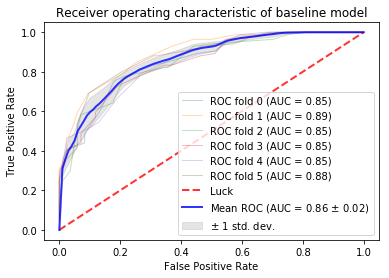

In [43]:
#plot the ROC curve with cross validation for baseline model
X_bl = np.array(X_train_baseline)
y_bl = np.array(y_train_baseline)

n_samples_bl, n_features_bl = X_bl.shape

# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv_bl = StratifiedKFold(n_splits=6)
classifier_bl = logreg_bl

tprs_bl = []
aucs_bl = []
mean_fpr_bl = np.linspace(0, 1, 100)

i = 0
for train, test in cv_bl.split(X_bl, y_bl):
    probas__bl = classifier_bl.fit(X_bl[train], y_bl[train]).predict_proba(X_bl[test])
    # Compute ROC curve and area the curve
    fpr_bl, tpr_bl, thresholds_bl = roc_curve(y_bl[test], probas__bl[:, 1])
    tprs_bl.append(interp(mean_fpr_bl, fpr_bl, tpr_bl))
    tprs_bl[-1][0] = 0.0
    roc_auc_bl = auc(fpr_bl, tpr_bl)
    aucs_bl.append(roc_auc_bl)
    plt.plot(fpr_bl, tpr_bl, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc_bl))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr_bl = np.mean(tprs_bl, axis=0)
mean_tpr_bl[-1] = 1.0
mean_auc_bl = auc(mean_fpr_bl, mean_tpr_bl)
std_auc_bl = np.std(aucs_bl)
plt.plot(mean_fpr_bl, mean_tpr_bl, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_bl, std_auc_bl),
         lw=2, alpha=.8)

std_tpr_bl = np.std(tprs_bl, axis=0)
tprs_upper_bl = np.minimum(mean_tpr_bl + std_tpr_bl, 1)
tprs_lower_bl = np.maximum(mean_tpr_bl - std_tpr_bl, 0)
plt.fill_between(mean_fpr_bl, tprs_lower_bl, tprs_upper_bl, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of baseline model')
plt.legend(loc="lower right")
plt.show()

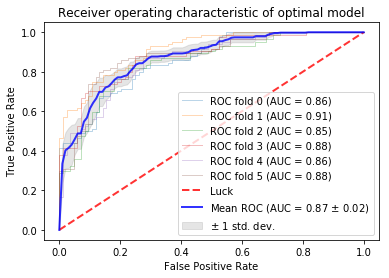

In [44]:
#plot the ROC curve with cross validation for optimal model
X = np.array(X_train)
y = np.array(y_train)

n_samples, n_features = X.shape

# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = logreg

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of optimal model')
plt.legend(loc="lower right")
plt.show()

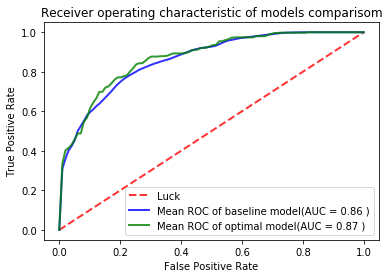

In [45]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr_bl = np.mean(tprs_bl, axis=0)
mean_tpr_bl[-1] = 1.0
mean_auc_bl = auc(mean_fpr_bl, mean_tpr_bl)
std_auc_bl = np.std(aucs_bl)
plt.plot(mean_fpr_bl, mean_tpr_bl, color='b',
         label=r'Mean ROC of baseline model(AUC = %0.2f )' % (mean_auc_bl),
         lw=2, alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='g',
         label=r'Mean ROC of optimal model(AUC = %0.2f )' % (mean_auc),
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of models comparisom')
plt.legend(loc="lower right")
plt.show()

- Both of the ROC curve is on the upper left corner, indicating a good discrimination. The average AUC value from cross validation of optimal model is 0.87, higher than that of baseline model, which is 0.86. Hence, the expected performance of the optimal model is better than baseline model. 


- The ROC curve of optimal model is slightly deeper at the beginning than that of baseline model. Kaggle punishs the prediction that something is true when it is actually false, the false positive prediction, which means we are looking for less false positive rate. So, the optimal model performs better, under the rule of Kaggle (https://www.kaggle.com/c/womens-machine-learning-competition-2018#evaluation)

### Summary

After checking Log Loss, Accuracy, Precision and recall, F1 measure, and ROC Curve with cross validation of training data, the optimal model performs better in all measurements: 
- Higher accuracy and F1 score; 
- less false positive rate and higher AUC in ROC curve; 
- and most important, less log loss score. 

### Log Loss on 2018 Tournament Result

After evaluate the models and make decision on our optimal model, we preicted the winning proberblities of 2018 tournment result by every possible matchups of teams, and compare the predicted matchups that actually happened with the 2018 tournament result and generate a log loss score to compared with the leaderboard in Kaggle. 

In [46]:
#Create the each team matchups ID for submission file
X_test_baseline_with_ID = df_tour_final_feats[['SeedDiff','1TeamID','2TeamID','Season']][df_tour_final_feats['Season'] == 2018]
X_test_baseline_with_ID['ID'] = X_test_baseline_with_ID.apply(lambda row: str(int(row['Season']))+'_'+ \
                                            str(int(row['1TeamID']))+'_'+ \
                                            str(int(row['2TeamID'])), axis=1) 
X_test_with_ID = df_tour_final_feats[['Season','1TeamID','2TeamID','SeedDiffPct','LeaguebinDiff','WinProb']]\
                    [df_tour_final_feats['Season'] == 2018]
X_test_with_ID['ID'] = X_test_with_ID.apply(lambda row: str(int(row['Season']))+'_'+ \
                                            str(int(row['1TeamID']))+'_'+ \
                                            str(int(row['2TeamID'])), axis=1) 

In [47]:
#Create the final prediction data frame and output the subission csv file
df_sub = pd.DataFrame(data=X_test_with_ID['ID'],columns=['ID'])
pred_sub = searchCV.predict_proba(X_test)
df_sub['Pred']=pred_sub[:,1]
df_sub.to_csv('NCAA_Pred_2018.csv', index=False)

#create the final test dataframe
#df_sub = pd.read_csv('NCAA_Pred_2018.csv')
df_result = pd.read_csv('NCAA_Result_2018.csv')
df_eval = df_result.merge(df_sub, left_on='ID', right_on='ID', how='left')
df_eval.head()

,ID,Result,Pred
0,2018_3163_3384,1,0.959154
1,2018_3274_3346,0,0.615477
2,2018_3125_3181,0,0.208890
3,2018_3208_3273,1,0.837981
4,2018_3138_3378,1,0.413795


In [48]:
y_pred = df_eval.loc[:,'Pred'].as_matrix()
y_true = df_eval.loc[:,'Result'].as_matrix()

print ('Log Loss of 2018 Tournament Result:', log_loss(y_true, y_pred, eps=1e-15))

Log Loss of 2018 Tournament Result: 0.431590444807


The log loss score for optimal model is 0.43159, which is a great outcome. The Log Loss score follows the evaluation criteria of Kaggle competition, we would be placed in the rank of 16 from 505 teams.

## Deployment

- This model is used to predict the winning percentage of the every possible 2016 matchups in the 2018 NCAA Tournament Women's. Once the tournament begins and we have the bracket frame, with the threshold of 50% winning probability, the model can help users predict the total bracket including the winner of the tournament.

- To extend the model, if rolling the date set years forward, users can also use this model to predict the winning probability of NCAA Tournament Women's of year 2019, 2020, so on and so forth. However, as time goes by, the effectiveness of the model may change by rules, environment, players, fundings, etc. So, adjusting the model accordingly, is necessary for the forture years prediction and coreponding support will be provided by be provided by the team for users.